In [1]:
import numpy as np
import pandas as pd
import os
import json
import faiss
import torch
import tensorflow as tf

2023-09-12 21:04:25.551675: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 21:04:26.068729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 21:04:27.174272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
CLIP_FEATURES_PATH = "clip-vit-b16-features/"

features = [os.path.join(CLIP_FEATURES_PATH,path) for path in os.listdir(CLIP_FEATURES_PATH)]
len(features)

737

In [3]:
len(features)

737

In [4]:
# tmp = np.array([])
# for feature in features:
#     if not len(tmp):
#         tmp = np.load(feature)

#     else:
#         v   = np.load(feature)
#         tmp = np.concatenate([tmp, v],axis=0)

# tmp.shape

In [5]:
# features[0].split("/")[-1].split(".")[0]

In [6]:
# feats = np.array([])
# pooling = tf.keras.layers.GlobalAveragePooling1D()
# df = pd.DataFrame()
# batch_size = 16
# for feature in features:
#     v = np.load(feature)
#     tmp_feats = []
#     new_row = pd.DataFrame()
#     for i in range(0,v.shape[0],batch_size):
#         batch = v[i:i+batch_size]
#         batch_avg = pooling(batch.reshape(-1,batch.shape[0],512))
        
#         if not len(tmp_feats):
            
#             tmp_feats = np.array(batch_avg)
#         else:
#             tmp_feats = np.concatenate([tmp_feats,batch_avg],axis = 0)
#         # print(tmp_feats.shape)
#         tmp_df = pd.DataFrame({"start":[i],
#                                "end":[i+batch_size],
#                                "Names":feature.split("/")[-1].split(".")[0]})
#         new_row = pd.concat([new_row,tmp_df],ignore_index=True)
    
    
#     df = pd.concat([df,new_row],ignore_index = True)
#     if not len(feats):
            
#         feats = tmp_feats
#     else:
#         feats = np.concatenate([feats,tmp_feats],axis = 0)
# feats = np.array(feats)
# feats.shape

In [7]:
# %%time
# dim = 512
# n_centroids = 200
# n_subq = 16
# n_bits = 8
# n_probe = 16
# coarse_quantizer = faiss.IndexFlatIP(dim)
# pq_frames = faiss.IndexIVFPQ(coarse_quantizer, dim, n_centroids, n_subq, n_bits)
# pq_frames.nprobe = n_probe
# faiss.normalize_L2(tmp)
# pq_frames.train(tmp)
# faiss.normalize_L2(tmp)
# pq_frames.add(tmp)


In [8]:
# del tmp
# faiss.write_index(pq_frames, "frames.index")

In [2]:
pq_frames = faiss.read_index("frames.index")

In [10]:
# %%time

# pq_video = faiss.IndexFlatL2(dim)
# # pq = faiss.IndexIVFPQ(coarse_quantizer, dim, n_centroids, n_subq, n_bits)
# faiss.normalize_L2(feats)

# pq_video.train(feats)
# faiss.normalize_L2(feats)

# pq_video.add(feats)

In [11]:
# del feats
# faiss.write_index(pq_video,"videos.index")

In [3]:
pq_videos = faiss.read_index("videos.index")

In [4]:
df = pd.read_parquet("map_video_segment.parquet")
df

,start,end,Names
0,0,48,L01_V001
1,48,96,L01_V001
2,96,144,L01_V001
3,144,192,L01_V001
4,192,240,L01_V001
...,...,...,...
48856,2208,2256,L20_V100
48857,2256,2304,L20_V100
48858,2304,2352,L20_V100
48859,2352,2400,L20_V100


In [5]:
all = pd.read_parquet("map_all_frame.parquet")
all

,Names,Name in name
0,L01_V001,0000000000.jpg
1,L01_V001,0000000003.jpg
2,L01_V001,0000000006.jpg
3,L01_V001,0000000009.jpg
4,L01_V001,0000000012.jpg
...,...,...
776180,L20_V100,0000002424.jpg
776181,L20_V100,0000002427.jpg
776182,L20_V100,0000002430.jpg
776183,L20_V100,0000002433.jpg


In [6]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import torch
#Load CLIP model
# model = SentenceTransformer('clip-ViT-B-32')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Encode an image:
img_model = SentenceTransformer('clip-ViT-B-16').to(device)



/home/paultran2734/anaconda3/envs/aigov/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [311]:
#Encode text descriptions
s = "Video of two young men driving and stopping in front of the house for a while. 2 dogs in the house barked at the two young men. A moment later, someone in the house came out to see the situation. The house has ornamental plants on the left side."
text_emb = img_model.encode([s])

#Compute cosine similarities 
# text_emb


In [312]:
text_emb.shape

(1, 512)

In [313]:
# %%time

input = text_emb
faiss.normalize_L2(input)
D,I = pq_videos.search(input,10000)
I

array([[30632, 23670, 30633, ...,  5465, 25034, 10651]])

In [314]:
res_df = df.iloc[I[0]].reset_index()
res_df.head(20)

,index,start,end,Names
0,30632,2544,2592,L14_V019
1,23670,1536,1584,L11_V017
2,30633,2592,2640,L14_V019
3,45782,1008,1056,L20_V045
4,41051,1488,1536,L19_V056
5,15641,3120,3168,L08_V001
6,23669,1488,1536,L11_V017
7,39892,1488,1536,L19_V034
8,41050,1440,1488,L19_V056
9,16349,3024,3072,L08_V010


In [301]:
# import matplotlib.pyplot as plt
# img_path = []
# for i in range(10):
#     res = res_df.iloc[i]
#     img_path.append(os.path.join("sample","keyframes",res["Names"],"0"*(4 - len(str(res["n"])))+str(res["n"])+".jpg"))


# n_row, n_col = 2, 5
# _, axs = plt.subplots(n_row, n_col,figsize=(30,10))
# axs = axs.flatten()
# for path, ax in zip(img_path, axs):
#     try:
#         img = Image.open(path)
#         ax.imshow(img, aspect='auto')
#     except:
#         continue
# plt.show()

In [317]:
features = pq_videos.get_feature(30632)

AttributeError: 'IndexFlat' object has no attribute 'get_feature'

In [302]:
HOME = "test"
VID_PATH = "sample1"

FRAME = os.listdir(os.path.join(HOME,VID_PATH))
f = []
for path in FRAME:
    f.append(Image.open(os.path.join(HOME,VID_PATH,path)))
f[:10]


KeyboardInterrupt



In [41]:
map = pd.read_parquet('mapkeyframe.parquet')
map = map.drop_duplicates("Names")[["Names","watch_url"]]
map[map["Names"]=="L11_V009"]

,Names,watch_url
2340,L11_V009,https://youtube.com/watch?v=zbdEtjKmEhQ


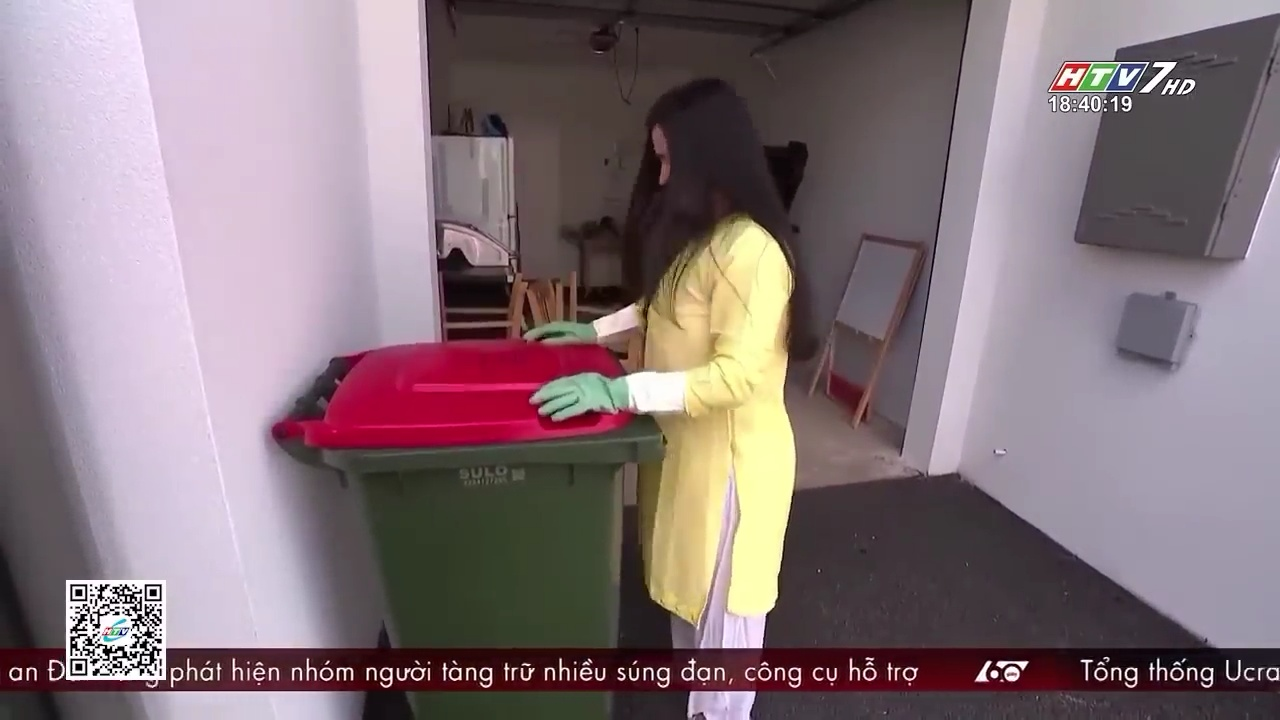

In [13]:
f[100]

In [25]:
a = img_model.encode(f, batch_size=16)

In [43]:
df = pd.DataFrame()
df.to_csv("submission.csv", header=False, index = False)


In [37]:
a.shape
b = pooling(a.reshape(-1,a.shape[0],512)).numpy()
b.shape

(1, 512)

In [38]:

faiss.normalize_L2(b)
D, I = pq_frames.search(b,10000)

In [39]:
I = I.flatten()
I

array([ 51896,  51891,  51889, ...,  73083, 112267, 292653])

In [40]:
from collections import Counter
z = list(Counter(I[:]).keys())[:100]

In [41]:
# features

In [42]:
all.iloc[z][:10]

,Names,Name in name
51896,L02_V016,0000001731.jpg
51891,L02_V016,0000001716.jpg
51889,L02_V016,0000001710.jpg
51887,L02_V016,0000001704.jpg
421012,L12_V023,0000002370.jpg
284449,L09_V002,0000001221.jpg
51888,L02_V016,0000001707.jpg
51892,L02_V016,0000001719.jpg
212764,L06_V028,0000002736.jpg
51890,L02_V016,0000001713.jpg


In [ ]:
features[159]

In [109]:
df

,n,pts_time,fps,frame_idx,Names,author,channel_id,channel_url,description,keywords,length,publish_date,thumbnail_url,title,watch_url
0,1,0.00,25.0,0,L01_V001,60 Giây Official,UCRjzfa1E0gA50lvDQipbDMg,https://www.youtube.com/channel/UCRjzfa1E0gA50...,None,[],1109,2022-12-01 00:00:00,https://i.ytimg.com/vi/HNsRpkryGXA/hqdefault.j...,60 Giây Sáng - Ngày 01/12/2022 - HTV Tin Tức M...,https://youtube.com/watch?v=HNsRpkryGXA
1,234,966.12,25.0,24153,L01_V002,60 Giây Official,UCRjzfa1E0gA50lvDQipbDMg,https://www.youtube.com/channel/UCRjzfa1E0gA50...,None,[],1040,2022-12-02 00:00:00,https://i.ytimg.com/vi/f4mLZEqyaCI/hqdefault.j...,60 Giây Sáng - Ngày 02/12/2022 - HTV Tin Tức M...,https://youtube.com/watch?v=f4mLZEqyaCI
2,91,368.00,25.0,9200,L02_V001,60 Giây Official,UCRjzfa1E0gA50lvDQipbDMg,https://www.youtube.com/channel/UCRjzfa1E0gA50...,None,[],1236,2022-12-02 00:00:00,https://i.ytimg.com/vi/7EDyaNggOMM/hqdefault.j...,60 Giây Chiều - Ngày 01/12/2022 - HTV Tin Tức ...,https://youtube.com/watch?v=7EDyaNggOMM
3,208,890.64,25.0,22266,L01_V003,60 Giây Official,UCRjzfa1E0gA50lvDQipbDMg,https://www.youtube.com/channel/UCRjzfa1E0gA50...,None,[],1002,2022-12-03 00:00:00,https://i.ytimg.com/vi/13fm6nkNcAQ/hqdefault.j...,60 Giây Sáng - Ngày 03/12/2022 - HTV Tin Tức M...,https://youtube.com/watch?v=13fm6nkNcAQ
4,255,1123.32,25.0,28083,L02_V002,60 Giây Official,UCRjzfa1E0gA50lvDQipbDMg,https://www.youtube.com/channel/UCRjzfa1E0gA50...,None,[],1240,2022-12-03 00:00:00,https://i.ytimg.com/vi/s2OP6wppymI/hqdefault.j...,60 Giây Chiều - Ngày 02/12/2022 - HTV Tin Tức ...,https://youtube.com/watch?v=s2OP6wppymI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115574,290,793.60,25.0,19840,L20_V100,Báo Tuổi Trẻ,UC47WI-kZXFf0H_f7pvaNCEQ,https://www.youtube.com/channel/UC47WI-kZXFf0H...,None,[],903,14/08/2023,https://i.ytimg.com/vi/aQqk5dfNcZI/hq720.jpg?s...,Góc nhìn trưa nay: Nhóm sinh viên sáng chế thi...,https://youtube.com/watch?v=aQqk5dfNcZI
115575,291,798.56,25.0,19964,L20_V100,Báo Tuổi Trẻ,UC47WI-kZXFf0H_f7pvaNCEQ,https://www.youtube.com/channel/UC47WI-kZXFf0H...,None,[],903,14/08/2023,https://i.ytimg.com/vi/aQqk5dfNcZI/hq720.jpg?s...,Góc nhìn trưa nay: Nhóm sinh viên sáng chế thi...,https://youtube.com/watch?v=aQqk5dfNcZI
115576,292,803.52,25.0,20088,L20_V100,Báo Tuổi Trẻ,UC47WI-kZXFf0H_f7pvaNCEQ,https://www.youtube.com/channel/UC47WI-kZXFf0H...,None,[],903,14/08/2023,https://i.ytimg.com/vi/aQqk5dfNcZI/hq720.jpg?s...,Góc nhìn trưa nay: Nhóm sinh viên sáng chế thi...,https://youtube.com/watch?v=aQqk5dfNcZI
115577,293,808.48,25.0,20212,L20_V100,Báo Tuổi Trẻ,UC47WI-kZXFf0H_f7pvaNCEQ,https://www.youtube.com/channel/UC47WI-kZXFf0H...,None,[],903,14/08/2023,https://i.ytimg.com/vi/aQqk5dfNcZI/hq720.jpg?s...,Góc nhìn trưa nay: Nhóm sinh viên sáng chế thi...,https://youtube.com/watch?v=aQqk5dfNcZI


In [122]:
e = df.iloc[a]

In [125]:
e[["Names","frame_idx"]].to_csv("submission.csv", index = False)

Videos_L01
L01_V001.mp4


In [3]:
os.listdir("Video")

['Videos_L01', 'Videos_L02', 'Videos_L03', 'Videos_L04', 'Videos_L05']

In [5]:
os.listdir(os.path.join(HOME,V_PATH))

['video']

In [6]:
os.path.join(HOME,V_PATH,"video")

'Video/Videos_L01/video'